In [1]:
import sys
sys.path.append("../")

In [2]:
import os.path as op
import random

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.legend_handler import HandlerTuple


import pandas as pd
import yaml

from agents import GreedyAgent,RandomAgent
from agents.matchmanager import MatchManager
from agents.ml.classifier import ClassifierAgent
from agents.ml.regression import RegressionAgent
from agents.ml.regressionMulti import RegressionMultiAgent

from core.const import RED, BLUE
from core.game import GameBoard, GameState, vectorState, vectorStateInfo
from core.vectors import vectorAction, vectorActionInfo, vectorBoard, vectorBoardInfo
from scenarios import scenarioJunction,scenarioJunctionExo
import warnings
import datetime

from sklearn import preprocessing

from multiprocessing import Pool
import pickle

from itertools import product
import json

import os
from utils.setup_logging import setup_logging
import joblib
import numpy as np




%matplotlib inline
plt.rcParams['figure.dpi']=100
plt.rcParams['figure.figsize'] = (12,4)


In [3]:
def player(team:str, data:tuple, seed:int):
    if data[0] == 'gre':
        #print(f'{team:5}-> GreedyAgent')
        return GreedyAgent(team, seed=seed)
    if data[0] == 'cls':
        #print(f'{team:5}-> ClassifierAgent')
        return ClassifierAgent(team, data[1], seed=seed)
    if data[0] == 'reg':
        #print(f'{team:5}-> RegressionAgent')
        return RegressionAgent(team, data[1], seed=seed)
    if data[0]=='ran':
        #print(f'{team:5}-> RandomAgent')
        return RandomAgent(team, seed=seed)
    if data[0]=='regMulti':
        #print(f'{team:5}-> RegressionAgentMulti')
        return RegressionMultiAgent(team,data[1],data[2],data[3],seed=seed)


    
    return None

In [4]:
def game(scenario,seed:int, red:tuple, blue:tuple) -> MatchManager:
    board, state = scenario()

    #print('seed:   ', seed)

    playerRed = player(RED, red, seed)
    playerBlue = player(BLUE, blue, seed)

    mm = MatchManager(' ', playerRed, playerBlue, board, state, seed=seed)
    while not mm.end:
        mm.nextStep()
    #print('winner: ', mm.winner)

    return mm,board.name,playerRed,playerBlue

In [5]:
def prepareDataFrames(mm:MatchManager):
    df_states = pd.DataFrame(
        columns=vectorStateInfo(),
        data=[vectorState(x) for x in mm.states_history]
    )

    df_actions = pd.DataFrame(
        columns=vectorActionInfo(),
        data=[vectorAction(x) for x in mm.actions_history]
    )

    df_board=pd.DataFrame(
        columns=vectorBoardInfo(),
        data=[vectorBoard(mm.board,x) for x in mm.states_history]
    )
    df_concat=pd.concat([df_states,df_actions,df_board],axis=1)
    df_concat.dropna(axis=1, how='all',inplace=True)
    
    df_red =pd.concat([mm.red.createDataFrame().reset_index(drop=True),df_concat[df_concat['action_team'] == 'red'].copy().drop('action_team', axis=1).reset_index(drop=True)],axis=1)

    df_blue =pd.concat([mm.blue.createDataFrame().reset_index(drop=True),df_concat[df_concat['action_team'] == 'blue'].copy().drop('action_team', axis=1).reset_index(drop=True)],axis=1)

    df_red['winner']=mm.winner
    df_blue['winner']=mm.winner
    


    return df_red, df_blue

In [6]:
def shiftMarker(df,winner):
    df_repl=df.tail(1)
    #action='Winner' if (df_repl.iloc[0]['team']=='red' and winner=='red') else 'Loser'
    #action='Winner' if (df_repl.iloc[0]['team']=='blue' and winner=='blue') else 'Loser'
    df_repl.index += 1
    
    df=df.append(df_repl)
    delta=datetime.timedelta(milliseconds=400)
    turn=(datetime.datetime.combine(datetime.date(1,1,1),df.iloc[-1]['time']) + delta).time()
    df.at[df.index[-1], 'time'] = turn
    if df.iloc[-1]['team']=='red':
        if df.iloc[-1]['winner']=='red':
            action='Winner'
        else:
            action='Loser'
    else:
        if df.iloc[-1]['winner']=='blue':
            action='Winner'
        else:
            action='Loser'
    df.at[df.index[-1], 'action'] = action
    df['score']=df['score'].shift(periods=1,fill_value=0)
    
    return df
    


In [7]:
def setTime(df,winner):

    df['time'] = pd.to_datetime(df['time'],errors='coerce')
    df['time']=df['time'].dt.time
    #df= df.reset_index()
    df=shiftMarker(df,winner)
    x=df['time'].tolist()
    y=df['score'].tolist()
    df= df.set_index('time')
    return df,x,y


In [8]:
def setScore(df,model_path):
    model=joblib.load(os.path.join(os.getcwd(), model_path[1]))
    df= df.reset_index()
    df['score']=model.predict(df.drop(['meta_scenario', 'meta_p_red', 'meta_p_blue', 'meta_seed','meta_id','count','time','team','seed','score','action','entropy','standard_deviation','n_scores','scores','actions','winner','random_choice','n_choices','index','count'], axis=1, errors="ignore"))
    return df

In [9]:
def separateAction(df):
    df_move=df.loc[(df['action'] == 'Move')].copy()
    df_attack=df.loc[(df['action'] == 'Attack')].copy()
    df_attackground=df.loc[(df['action'] == 'AttackGround')].copy()
    df_moveloadinto=df.loc[(df['action'] == 'MoveLoadInto')].copy()
    df_passfigure=df.loc[(df['action'] == 'PassFigure')].copy()
    df_pass=df.loc[(df['action'] == 'Pass')].copy()
    df_passteam=df.loc[(df['action'] == 'PassTeam')].copy()
    df_attackrespond=df.loc[(df['action'] == 'AttackRespond')].copy()
    df_passrespond=df.loc[(df['action'] == 'PassRespond')].copy()
    
    
    return df_move,df_attack,df_attackground,df_moveloadinto,df_passfigure,df_pass,df_passteam,df_attackrespond,df_passrespond


    

    

In [10]:
def plotEntropyTime(df_red,df_blue,red_data,blue_data,winner,scenario,model_path):
    df_red.dropna(inplace=True)
    df_blue.dropna(inplace=True)
    position=[]
    labels=df_red['turn'].unique().tolist()
    labels_legend=['Score','Entropy']
    loser='blue' if winner == 'red' else 'red'
    

    df_red=setScore(df_red,model_path)
    df_blue=setScore(df_blue,model_path)


    df_red,x_red,y_red=setTime(df_red,winner)
    df_blue,x_blue,y_blue=setTime(df_blue,winner)
    
    
    if(red_data[0]=='ran'):
        df_red['standard_deviation']=0
    if(blue_data[0]=='ran'):
        df_blue['standard_deviation']=0
        
    df_red['standard_deviation']=df_red['standard_deviation'].mul(-1)


    fig, ax = plt.subplots()
    df_move_r,df_attack_r,df_attackground_r,df_moveloadinto_r,df_passfigure_r,df_pass_r,df_passteam_r,df_attackrespond_r,df_passrespond_r=separateAction(df_red)
    df_move_b,df_attack_b,df_attackground_b,df_moveloadinto_b,df_passfigure_b,df_pass_b,df_passteam_b,df_attackrespond_b,df_passrespond_b=separateAction(df_blue)

    df_red.score.plot(color='red',legend=False,ax=ax,label='_nolegend_')
    df_blue.score.plot(color='blue',legend=False,ax=ax,label='_nolegend_')
    df_red.standard_deviation.plot(color='red',legend=False,ax=ax,style='--',linewidth=0.5,label='_nolegend_')
    df_blue.standard_deviation.plot(color='blue',legend=False,ax=ax,style='--',linewidth=0.5,label='_nolegend_')
    
    df_move_r.score.plot(color='red',marker='D',linestyle='None',label='_nolegend_',legend=False)
    df_move_b.score.plot(color='blue',marker='D',linestyle='None',label='_nolegend_',legend=False)


    df_attack_r.score.plot(color='red',marker='o',linestyle='None',label='_nolegend_',legend=False)
    df_attack_b.score.plot(color='blue',marker='o',linestyle='None',label='_nolegend_',legend=False)

    
    df_attackground_r.score.plot(color='red',marker='p',linestyle='None',label='_nolegend_',legend=False)
    df_attackground_b.score.plot(color='blue',marker='p',linestyle='None',label='_nolegend_',legend=False)

    
    df_moveloadinto_r.score.plot(color='red',marker='*',linestyle='None',label='_nolegend_',legend=False)
    df_moveloadinto_b.score.plot(color='blue',marker='*',linestyle='None',label='_nolegend_',legend=False)

    
    df_passfigure_r.score.plot(color='red',marker='v',linestyle='None',label='_nolegend_',legend=False)
    df_passfigure_b.score.plot(color='blue',marker='v',linestyle='None',label='_nolegend_',legend=False)

    
    df_pass_r.score.plot(color='red',marker='P',linestyle='None',label='_nolegend_',legend=False)
    df_pass_b.score.plot(color='blue',marker='P',linestyle='None',label='_nolegend_',legend=False)

    
    df_passteam_r.score.plot(color='red',marker='<',linestyle='None',label='_nolegend_',legend=False)
    df_passteam_b.score.plot(color='blue',marker='<',linestyle='None',label='_nolegend_',legend=False)

    
    df_attackrespond_r.score.plot(color='red',marker='X',linestyle='None',label='_nolegend_',legend=False)
    df_attackrespond_b.score.plot(color='blue',marker='X',linestyle='None',label='_nolegend_',legend=False)

    
    df_passrespond_r.score.plot(color='red',marker='s',linestyle='None',label='_nolegend_',legend=False)
    df_passrespond_b.score.plot(color='blue',marker='s',linestyle='None',label='_nolegend_',legend=False)
    
    
    list_graphs = [child for child in ax.get_children() if isinstance(child, Line2D)]
    
    lists_legend=[(list_graphs[0],list_graphs[1]),(list_graphs[2],list_graphs[3])]
    dict_df={
            'Move':(df_move_r,df_move_b,list_graphs[4],list_graphs[5]),
             'Attack':(df_attack_r,df_attack_b,list_graphs[6],list_graphs[7]),
            'AttackGround':(df_attackground_r,df_attackground_b,list_graphs[8],list_graphs[9]),
            'MoveLoadInto':(df_moveloadinto_r,df_moveloadinto_b,list_graphs[10],list_graphs[11]),
             'PassFigure':(df_passfigure_r,df_passfigure_b,list_graphs[12],list_graphs[13]),
             'Pass':(df_pass_r,df_pass_b,list_graphs[14],list_graphs[15]),
             'PassTeam':(df_passteam_r,df_passteam_b,list_graphs[16],list_graphs[17]),
             'AttackRespond':(df_attackrespond_r,df_attackrespond_b,list_graphs[18],list_graphs[19]),
             'PassRespond':(df_passrespond_r,df_passrespond_b,list_graphs[20],list_graphs[21]),
            }
    
    for key in dict_df:
        if not dict_df[key][0].empty or not dict_df[key][1].empty:
            labels_legend.append(key)
            if not dict_df[key][0].empty and dict_df[key][1].empty:
                lists_legend.append(dict_df[key][2])
            elif dict_df[key][0].empty and not dict_df[key][1].empty:
                lists_legend.append(dict_df[key][3])
            else:
                lists_legend.append((dict_df[key][2],dict_df[key][3]))

    if df_red.iloc[-1]['action']=='Winner':
        df_red.loc[(df_red['action'] == 'Winner')].score.plot(color='red',marker='o',linestyle='None',fillstyle='none',label='Winner',legend=False)
        labels_legend.append('Winner')
    else:
        df_red.loc[(df_red['action'] == 'Loser')].score.plot(color='red',marker='x',linestyle='None',fillstyle='none',label='Loser',legend=False)
        labels_legend.append('Loser')

    if df_blue.iloc[-1]['action']=='Winner':
        df_blue.loc[(df_blue['action'] == 'Winner')].score.plot(color='blue',marker='o',linestyle='None',fillstyle='none',label='Winner',legend=False)
        labels_legend.append('Winner')
        
    else:
        df_blue.loc[(df_blue['action'] == 'Loser')].score.plot(color='blue',marker='x',linestyle='None',fillstyle='none',label='Loser',legend=False)
        labels_legend.append('Loser')
        
    list_graphs = [child for child in ax.get_children() if isinstance(child, Line2D)]

    lists_legend.append(list_graphs[22])
    lists_legend.append(list_graphs[23])

    
    for x in df_red[['turn']].reset_index().groupby('turn').min().values.tolist():
        delta=datetime.timedelta(milliseconds=20)
        turn=(datetime.datetime.combine(datetime.date(1,1,1),x[0]) - delta).time()
        ax.axvline(x=turn, color='black',linewidth=0.7)
        position.append(turn)

    ax.vlines(x_red, -1, y_red, linestyle=':',linewidth=0.5,color='red',alpha=0.5)
    ax.vlines(x_blue, -1, y_blue, linestyle=':',linewidth=0.5,color='blue',alpha=0.5)
    ax.axhline(color='black',linewidth=0.5)
    
    position.append((datetime.datetime.combine(datetime.date(1,1,1),max(x_blue)) +datetime.timedelta(milliseconds=15)).time())
    labels.append('Game Over')
    labels[0]='Game starts'
    plt.xticks(position, labels)
    plt.yticks([-1,0,1], ['likely to win','neutral','likely to lose'])

    legend_elements = [Line2D([0], [0], color='red', label=f'Attacker ({red_data[0]})'),
                   Line2D([0], [0], color='blue', label=f'Defender ({blue_data[0]})')]

    leg1 = ax.legend(lists_legend, labels_legend,bbox_to_anchor=(1,1), loc="upper left",
               handler_map={tuple: HandlerTuple(ndivide=None)})    
    leg2 = ax.legend(handles=legend_elements, loc='upper left')
    ax.add_artist(leg1)
    ax.set_ylim(-1,+1)
    ax.set_xlim(right=(datetime.datetime.combine(datetime.date(1,1,1),max(x_blue)) +datetime.timedelta(milliseconds=15)).time())
    ax.set_xlabel('Turn')
    title=f'Scenario {scenario}. Winner {winner}, loser: {loser} '
    ax.set_title(title)
    return df_red,df_blue


def plotContrast(df):
    df[df['team']=='red']['entropy'].plot(color='red'), df[df['team']=='blue']['entropy'].plot(color='blue')

In [11]:
def playAndAnalyzeTime(scenario,seed:int, red_data, blue_data,model_path):
    mm,scenario,_,_ = game(scenario,seed, red_data, blue_data)
       
    df_red, df_blue= prepareDataFrames(mm)

    plotEntropyTime(df_red,df_blue,red_data,blue_data,mm.winner,scenario,model_path)
    
    plt.show()
    
    return df_red, df_blue

In [12]:
red_models = [
    ('gre', ''),
    ('ran',''),
    #('cls', '../models/Junction_RandomForestClassifier_red_20210301.joblib'),
    ('cls', '../models/Junction_RandomForestClassifier_20210301.joblib'),
    #('reg', '../models/Junction_RandomForestRegressor_red_20210301.joblib'),
    ('reg', '../models/Junction_RandomForestRegressor_20210301.joblib'),
    ('regMulti','../models/Junction_RandomForestRegressor_red_attack_20210301.joblib','../models/Junction_RandomForestRegressor_red_move_20210301.joblib','../models/Junction_RandomForestRegressor_red_pass_20210301.joblib')

]
blue_models = [
    ('gre', ''),
    ('ran',''),
    #('cls', '../models/Junction_RandomForestClassifier_blue_20210301.joblib'),
    ('cls', '../models/Junction_RandomForestClassifier_20210301.joblib'),
    #('reg', '../models/Junction_RandomForestRegressor_blue_20210301.joblib'),
    ('reg', '../models/Junction_RandomForestRegressor_20210301.joblib'),
    ('regMulti','../models/Junction_RandomForestRegressor_blue_attack_20210301.joblib','../models/Junction_RandomForestRegressor_blue_move_20210301.joblib','../models/Junction_RandomForestRegressor_blue_pass_20210301.joblib')
]

In [13]:
def play(args):
    scenario,seed,red_data,blue_data,model_path=args
    mm,scenario,playerRed,playerBlue = game(scenario,seed, red_data, blue_data)

    
    df_red, df_blue= prepareDataFrames(mm)

    df_r,df_b=plotEntropyTime(df_red,df_blue,red_data,blue_data,mm.winner,scenario,model_path)
    max_score= 'red' if df_r.iloc[-1]['score']>df_b.iloc[-1]['score'] else 'blue'

    save={
        'scenario':scenario,
        'seed':seed,
        'teamRed':playerRed.name,
        'teamBlue':playerBlue.name,
        'winner':mm.winner,
        'playerWithMaxScore':max_score
    }
    file_name=f'../output/{playerRed.name}_{playerBlue.name}_{scenario}_{seed}.json'
    #print(file_name)
    with open(file_name, 'w') as json_file:
        json.dump(save, json_file)
    
    #plt.show()
    file_name=f'../graphs/{playerRed.name}_{playerBlue.name}_{scenario}_{seed}.png'
    plt.savefig(file_name)

    #df_red.to_csv('df_red.csv')
    #df_blue.to_csv('df_blue.csv')
    
    return df_red, df_blue

In [ ]:
args=[]
#scenarios = [scenarioJunction,scenarioJunctionExo]
scenarios = [scenarioJunction]

for i in range(1000):
    for scenario in scenarios:
        for agentRed, agentBlue in product(red_models, blue_models):
            args.append((scenario,i,agentRed,agentBlue,red_models[3]))

In [ ]:
with Pool(64) as p:
    p.map(play, args)

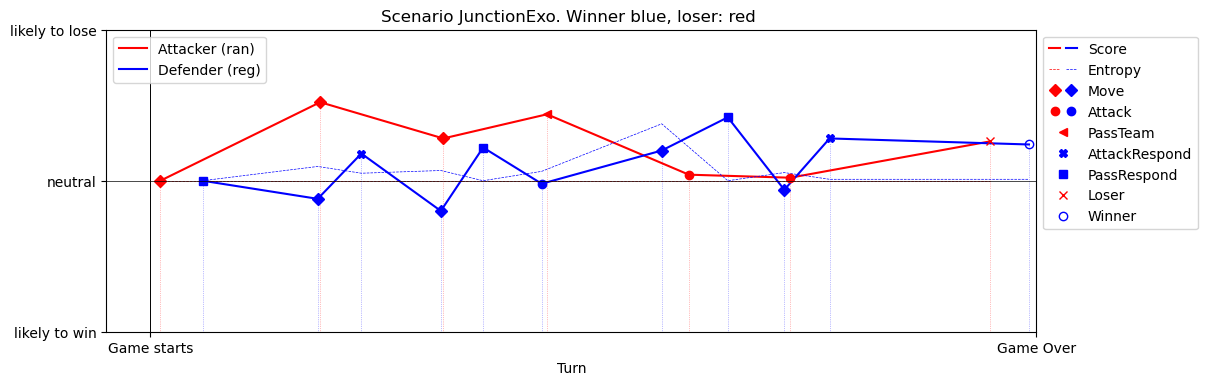

In [14]:
d_r,d_b=playAndAnalyzeTime(scenarioJunctionExo,122340, red_models[1], blue_models[3],red_models[3])


In [ ]:
d_r,d_b=playAndAnalyzeTime(122340, red_models[0], blue_models[3],red_models[3])


setup_logging()


In [ ]:
df_red,df_blue=playAndAnalyzeTime(1200, red_models[0], blue_models[1],red_models[5])


In [ ]:
plotEntropyTime(df_r,df_b,('reg', ''),('cls', ''),mm.winner,'Junction',('reg', '../models/Junction_RandomForestRegressor_20210301.joblib'))

## Tourney 

In [ ]:
dfs=[]
for i in range(3):
    s = random.randint(0, 1000000)
    r = random.randint(0, len(red_models)-1)
    b = random.randint(0, len(blue_models)-1)
    df_red,df_blue=playAndAnalyzeTime(s, red_models[r], blue_models[b])
    dfs.append(df_red)
    dfs.append(df_blue)
df=pd.concat(dfs).reset_index()

## Entropy regressor

entropyAndScore(df,'scatter')

entropyAndScore(df,'line')

fig, axes = plt.subplots(1,len(df['seed'].unique()), figsize=(15,5))
for (joinGroup, group), ax in zip(df.groupby(['seed']), axes.flatten()):
    win=group['winner'].unique()
    title=f'{joinGroup}-> winner:{win}'
    group.plot(x=['count'], y=['score'], kind='scatter', ax=ax,title=title,ylim=[-1,1],c='team')


plot=df.groupby(['team','seed']).plot.bar(y='entropy')

boxplot=df.boxplot(column=['score', 'entropy'],by='team')


boxplot=df.boxplot(column=['score', 'entropy'],by='seed')

boxplot=df.boxplot(column=['score', 'entropy'],by=['seed','team'])

plot=df.groupby('team').plot.scatter(x='count',y='entropy',c='team')

plot=df.groupby('team').plot.scatter(x='count',y='score',c='team')

def plotEntropy(df, color:str,data,winner,ax):
    df.score.plot(color=color, marker='.',ax=ax)
    df.entropy.plot(color='purple',ax=ax)
    df.standard_deviation.plot(color='green',ax=ax)

    for i, row in df[['score','action']].reset_index().iterrows():
        dy, ha, va = (-0, 'center', 'top') if 'Respond' in row.action else (10, 'center', 'bottom')
        ax.annotate(row.action, (row['count'], row.score), ha=ha, va=va, rotation=90, textcoords="offset points", xytext=(0,dy))
        
    for x in df[['turn']].reset_index().groupby('turn').max().values.tolist():
        ax.axvline(x=x[0]+0.5, color='orange')
    ax.legend(framealpha=1, frameon=True,loc='center left',bbox_to_anchor=(1,0.5))
    title=f'Entropy and Score for agent->{data[0]}. Winner:{winner} '

    ax.set_title(title)


    

def playAndAnalyze(seed:int, red_data, blue_data):  
    mm,scenario = game(seed, red_data, blue_data)
        
    df_red, df_blue, _, _ = prepareDataFrames(mm)
    
    fig,(ax1,ax2)=plt.subplots(nrows=2,ncols=1,figsize=(12,12))
    plotEntropy(df_red, 'red',red_data,mm.winner,ax1)
    plotEntropy(df_blue, 'blue',blue_data,mm.winner,ax2)
    
    plt.show()
    
    return df_red, df_blue